In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import klib
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [8]:
import warnings
warnings.filterwarnings("ignore")

Extra pre processing

In [7]:
sales['Item_Identifier']=sales['Item_Identifier'].str[0:2]
sales['Item_Identifier'].value_counts()

NameError: name 'sales' is not defined

In [9]:
test= pd.read_csv("test.csv")
dataset= pd.read_csv("train.csv")
df= pd.concat([dataset,test], axis=0).reset_index()
df.loc[(df['Item_Fat_Content']=='LF') | (df['Item_Fat_Content']=='low fat') | (df['Item_Fat_Content']=='LOW'),'Item_Fat_Content']='Low Fat'
df.loc[(df['Item_Fat_Content']=='reg'),'Item_Fat_Content']='Regular'
df.Item_Fat_Content.unique()
df['Item_Visibility'].replace(0.0,value=np.nan,inplace=True)
df['Item_Visibility']=df['Item_Visibility'].fillna(df.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))
df["Item_Weight"]=df[["Item_Weight"]].fillna(df["Item_Weight"].mean())
mode_val=df[["Outlet_Size","Outlet_Type"]].pivot_table(index='Outlet_Type', aggfunc=(lambda x: x.mode()))
missing=df["Outlet_Size"].isnull()
df.loc[missing, "Outlet_Size"]=df.loc[missing, "Outlet_Type"].apply(lambda x: mode_val.loc[x])
df=klib.convert_datatypes(df)
df

,index,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0,FDA15,9.300000,Low Fat,0.016047,Dairy,249.809204,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.137939
1,1,DRC01,5.920000,Regular,0.019278,Soft Drinks,48.269199,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.422791
2,2,FDN15,17.500000,Low Fat,0.016760,Meat,141.617996,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.270020
3,3,FDX07,19.200001,Regular,0.022930,Fruits and Vegetables,182.095001,OUT010,1998,Small,Tier 3,Grocery Store,732.380005
4,4,NCD19,8.930000,Low Fat,0.014670,Household,53.861401,OUT013,1987,High,Tier 3,Supermarket Type1,994.705200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,5676,FDB58,10.500000,Regular,0.013496,Snack Foods,141.315399,OUT046,1997,Small,Tier 1,Supermarket Type1,NaN
14200,5677,FDD47,7.600000,Regular,0.142991,Starchy Foods,169.144806,OUT018,2009,Medium,Tier 3,Supermarket Type2,NaN
14201,5678,NCO17,10.000000,Low Fat,0.073529,Health and Hygiene,118.744003,OUT045,2002,Small,Tier 2,Supermarket Type1,NaN
14202,5679,FDJ26,15.300000,Regular,0.098200,Canned,214.621796,OUT017,2007,Small,Tier 2,Supermarket Type1,NaN


***
# 3. DATA PREPROCESSING FOR MODEL
***
## i) Encoding
~ Will one hot encoding give better accuracy?

For ordinal variables, no.

Example: for a data
- a > b > c > d

For x => a (real), Its better that the model predicts:
- x => b (predicted ordinally) 
- than 
- x => d (predicted nominally)

#### One Hot Encoder
- Creates alot of categories
- Only used for two nominal columns

! Take only top 10 categories if model efficiency is compromised because of columns

In [10]:
from sklearn.preprocessing import OneHotEncoder
oneHot= OneHotEncoder()

x=oneHot.fit_transform(df[["Item_Type","Outlet_Identifier"]]).toarray()
y=oneHot.get_feature_names_out()
df1=pd.concat([df,pd.DataFrame(x, columns=y)], axis=1)
# pd.DataFrame(x, columns=y).size

In [11]:
df1=df1.drop(columns=["Item_Type", "Outlet_Identifier", "index", "Item_Identifier"])
df1.tail(2)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Baking Goods,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
14202,15.3,Regular,0.09820,214.621796,2007,Small,Tier 2,Supermarket Type1,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14203,9.5,Regular,0.10472,79.795998,2002,Small,Tier 2,Supermarket Type1,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Label Encoder
- Easier to implement 
- but should be used only for target variable

Label encoder has encoded Outlet Size as
- High>Medium>Small (Alphabetically)
- 0, 1, 2
- Changing the order through ordinal encoder
 
==> Its better to use ordinal encoder for dependant variables

In [12]:
# from sklearn.preprocessing import LabelEncoder
# labelencoder= LabelEncoder()

# df1[["Item_Fat_Content", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]]=df[["Item_Fat_Content",
#     "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]].apply(labelencoder.fit_transform)
# df1.iloc[:,:15]

#### Ordinal Encoder
- Same as label encoder
- But we can specify order

Eg- Cold, hot, warm
- Label Encoder => 0,1,2 (alphabetically)
- Ordinal Encoder => 0,1,2 (alphabetically)
- But we have option to give cold>warm>hot 
- Hence: Cold, hot, warm => 0,2,1

In [13]:
from sklearn.preprocessing import OrdinalEncoder

outlet_size_encoder= OrdinalEncoder(categories=[["Small","Medium", "High"]], dtype=np.str_)
ordencoder= OrdinalEncoder()

df1[["Item_Fat_Content", "Outlet_Location_Type", "Outlet_Type"]]=ordencoder.fit_transform(df1[["Item_Fat_Content", "Outlet_Location_Type", "Outlet_Type"]])
df1[["Outlet_Size"]]=outlet_size_encoder.fit_transform(df1[["Outlet_Size"]])
df1

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Baking Goods,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.300000,0.0,0.016047,249.809204,1999,1,0.0,1.0,3735.137939,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5.920000,1.0,0.019278,48.269199,2009,1,2.0,2.0,443.422791,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17.500000,0.0,0.016760,141.617996,1999,1,0.0,1.0,2097.270020,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,19.200001,1.0,0.022930,182.095001,1998,0,2.0,0.0,732.380005,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.930000,0.0,0.014670,53.861401,1987,2,2.0,1.0,994.705200,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,10.500000,1.0,0.013496,141.315399,1997,0,0.0,1.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14200,7.600000,1.0,0.142991,169.144806,2009,1,2.0,2.0,NaN,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14201,10.000000,0.0,0.073529,118.744003,2002,0,1.0,1.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14202,15.300000,1.0,0.098200,214.621796,2007,0,1.0,1.0,NaN,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ii) Train Test Split

leave categorical

In [14]:
train_data=df1.iloc[:8523]
test_data=df1.iloc[8523:]
y=train_data[["Item_Outlet_Sales"]]
x=train_data.drop(columns="Item_Outlet_Sales")
x

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Type_Baking Goods,Item_Type_Breads,...,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.300000,0.0,0.016047,249.809204,1999,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5.920000,1.0,0.019278,48.269199,2009,1,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17.500000,0.0,0.016760,141.617996,1999,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,19.200001,1.0,0.022930,182.095001,1998,0,2.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.930000,0.0,0.014670,53.861401,1987,2,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,6.865000,0.0,0.056783,214.521805,1987,2,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8519,8.380000,1.0,0.046982,108.156998,2002,0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8520,10.600000,0.0,0.035186,85.122398,2004,0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8521,7.210000,1.0,0.145221,103.133202,2009,1,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30)

## iii) Standardization
#### Does not make much difference here

fit_transform() ==> Train data 

transform() ==>Test data
- so that params are not computed again
- overfitting is avoided

In [17]:
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [18]:
x_train_df=pd.DataFrame(x_train, columns=x.columns)
x_test_df=pd.DataFrame(x_test, columns=x.columns)
y_train_df=pd.DataFrame(y_train, columns=y.columns)
y_test_df=pd.DataFrame(y_test, columns=y.columns)

***
# 4) APPLYING ML MODELS
***

# Linear Models

## 1. Linear Regression:

feature names variable

In [266]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model.fit() ==> Train data

model.predict() ==> Test data

In [298]:
linear_reg= LinearRegression()

linear_reg.fit(x_train_df, y_train_df)
y_pred=linear_reg.predict(x_test_df)

<Axes: ylabel='Density'>

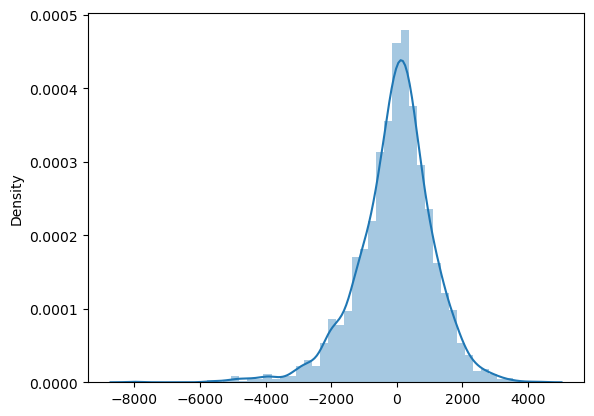

In [299]:
sns.distplot(y_pred-y_test)

Aligning with Linear Regression Assumption that
- Residuals should be normally distributed

In [300]:
linear_reg.score(x_test,y_test)

0.5563118337404124

In [301]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred, squared=False))

0.5563118337404124
854.509494956793
1166.8621352776436


In [302]:
np.mean(cross_val_score(linear_reg, x_train, y_train, scoring='r2', cv=5))

0.5603833599573047

In [303]:
linear_reg.coef_
# linear_reg.intercept_

array([[-1.11928351e+01,  2.60648124e+01, -1.43656497e+01,
         9.57990647e+02, -1.44479922e+15, -8.08201567e+14,
         1.20963743e+14, -8.78725938e+14,  6.33239400e+13,
         4.07694803e+13,  2.62022966e+13,  6.39564001e+13,
         6.46421084e+13,  7.13091853e+13,  8.38354867e+13,
         3.75551080e+13,  5.72661483e+13,  7.41602828e+13,
         5.15883318e+13,  3.47967775e+13,  2.01611268e+13,
         8.16410669e+13,  5.32200905e+13,  3.05971332e+13,
        -1.07331111e+15, -8.45396987e+14, -4.64633508e+14,
         3.10315773e+14, -1.51278693e+15, -6.40490715e+14,
        -6.18227705e+14, -7.25660181e+14, -9.77418578e+14,
        -4.84961750e+14]])

<Axes: xlabel='Weightage', ylabel='Feature'>

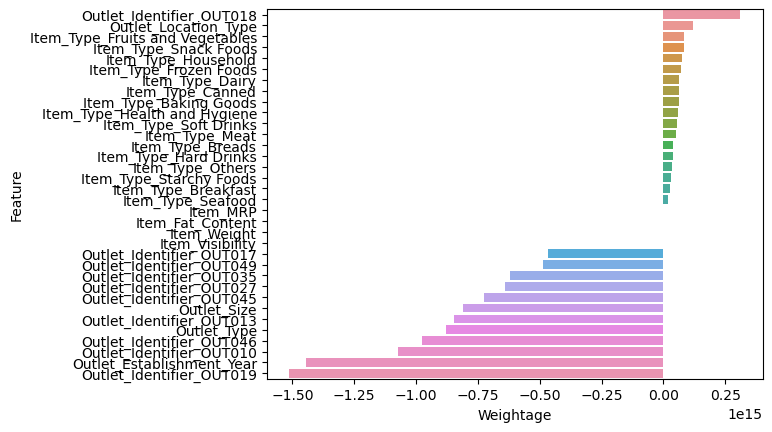

In [307]:
# list(enumerate(x.columns))
coef_dict=dict()

for i in range(x_train_df.shape[1]):
    coef_dict[x_train_df.columns[i]]=linear_reg.coef_[0][i].round(5)

feature=pd.DataFrame(sorted(coef_dict.items(), key=lambda kv:(kv[1], kv[0]), reverse=True), columns=["Feature", "Weightage"])
feature.head()
sns.barplot(feature, y='Feature', x="Weightage")

In [308]:
explainer_1 = shap.Explainer(linear_reg.predict, x_train_df)
shap_values_1= explainer_1(x_test_df)

Permutation explainer: 2558it [01:37, 23.23it/s]                                                                       


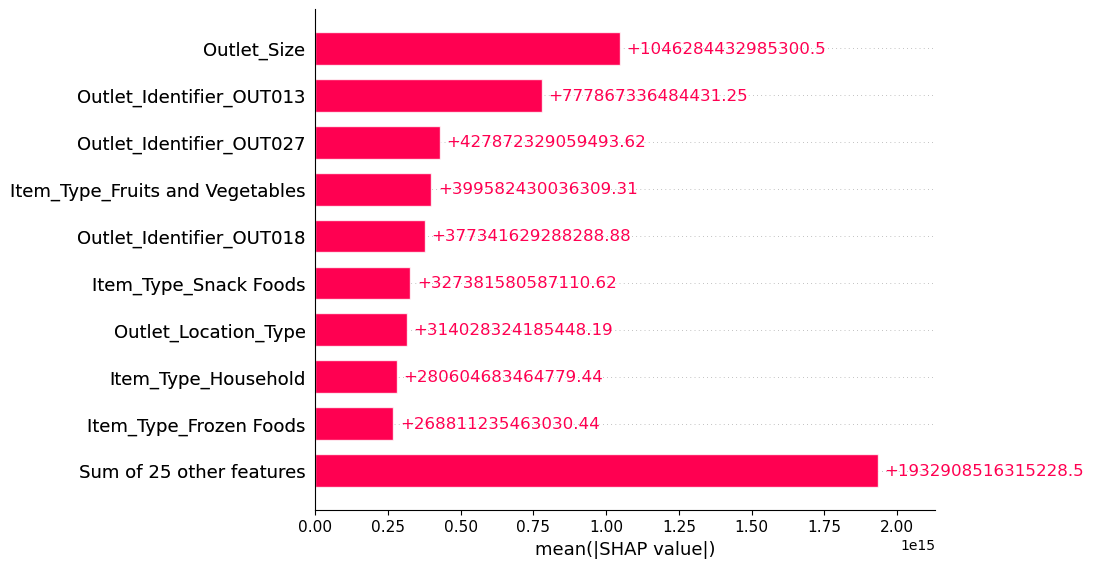

In [309]:
shap.plots.bar(shap_values)

Waterfall error!

In [ ]:
shap.plots.waterfall(shap_values_1[2])

## 2. Polynomial Regression:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [176]:
polynomial_features= PolynomialFeatures(degree=2)

x_poly = polynomial_features.fit_transform(x_train)
x_poly_test =  polynomial_features.transform(x_test)

model = LinearRegression()
polynomial_features.fit(x_poly, y_train)
model.fit(x_poly, y_train)

LinearRegression()

In [177]:
y_poly_pred = model.predict(x_poly_test)

In [178]:
print(r2_score(y_test,y_poly_pred))
print(mean_absolute_error(y_test,y_poly_pred))
print(mean_squared_error(y_test,y_poly_pred, squared=False))

0.5693422653601079
786.9952026041962
1120.6016795636529


In [68]:
print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred, squared=False))

0.5635134153465564
832.071973067482
1113.3946395147648


In [58]:
model.coef_
# model.intercept_

array([[-1.36435105e+10, -1.57733555e+01,  3.21283350e+01,
        -3.40594474e+01,  9.65863873e+02, -7.47086838e+14,
        -1.16653299e+15, -3.06048991e+15, -3.80656556e+14,
        -6.74795715e+14, -4.34740553e+14, -2.96339449e+14,
        -6.79687071e+14, -6.96768938e+14, -7.81716432e+14,
        -9.08869546e+14, -4.22501010e+14, -6.20619166e+14,
        -8.00038401e+14, -5.50416610e+14, -3.58739363e+14,
        -2.07627136e+14, -8.87561826e+14, -5.78755659e+14,
        -3.37189408e+14,  1.06385502e+15,  2.26362370e+15,
         5.59934213e+14,  2.46197742e+15, -1.07611310e+15,
         1.93370859e+15,  4.77270990e+14,  4.19374182e+14,
        -8.83949126e+14, -3.06105941e+14]])

##### Result
- Similar to linear reg, polynomial of degree 2 fits well 
- Performs just slightly better

## 3. Ridge Regression:

In [69]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [74]:
ridge_reg =  Ridge(alpha=35)

In [75]:
## Hyperparameter tuning

parameters={'alpha':[x for x in range(35,45)]}
ridgecv =GridSearchCV(ridge_reg, parameters, scoring="r2", cv=5)
ridgecv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(alpha=35),
             param_grid={'alpha': [35, 36, 37, 38, 39, 40, 41, 42, 43, 44]},
             scoring='r2')

In [185]:
ridgecv.best_params_

{'alpha': 35}

In [186]:
ridgecv.best_score_

0.5692248339376835

In [187]:
ridge_reg.fit(x_train,y_train)
y_ridge_pred=ridge_reg.predict(x_test)

In [188]:
r2_score(y_test,y_ridge_pred)

0.5401648409264472

##### Result
- Doesn't do much

## 4. Lasso Regression:

In [87]:
from sklearn.linear_model import Lasso

In [92]:
lasso_reg= Lasso(alpha=13)

#### HyperParameter Tuning

In [93]:
parameters={'alpha':[x for x in range(1,25)]}
lassocv =GridSearchCV(lasso_reg, parameters, scoring="r2", cv=5)
lassocv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(alpha=13),
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                   24]},
             scoring='r2')

In [94]:
print("Features seen:",lassocv.n_features_in_)
print(lassocv.best_params_)
print(lassocv.best_score_)

Features seen: 34
{'alpha': 13}
0.5599244454324502


In [95]:
lasso_reg.fit(x_train,y_train)
y_lasso_pred=lasso_reg.predict(x_test)
r2_score(y_test,y_lasso_pred)

0.5633993189971637

In [200]:
# from sklearn.feature_selection import SelectFromModel

In [201]:
# removed features
# sel_ = SelectFromModel(lasso)
# sel_.fit(scaler.transform(x_train), y_train)
# (sel_.estimator_.coef_ == 0).ravel().tolist()

#### Result
- Not much difference

# Tree Models

## 1. Decision Tree:

In [14]:
from sklearn.tree import DecisionTreeRegressor

In [70]:
decision_tree_reg= DecisionTreeRegressor()
decision_tree_reg.fit(x_train_df,y_train_df)
print(decision_tree_reg.get_depth())
print(decision_tree_reg.score(x_test,y_test))

40
0.15726641863902946


#### Hyper Parameter Tuning

In [71]:
parameters={"max_depth":[x for x in range(1,30)]}
decision_tree_cv =GridSearchCV(decision_tree_reg, parameters, scoring="r2", cv=5)
decision_tree_cv.fit(x_train,y_train)
print(decision_tree_cv.best_params_)
print(decision_tree_cv.best_score_)

{'max_depth': 5}
0.5862884589278833


In [13]:
x_train_df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049'],
      dtype='object')

In [52]:
decision_tree_reg= DecisionTreeRegressor( max_depth=6,min_samples_split=205,min_samples_leaf=32)
decision_tree_reg.fit(x_train_df[["Item_MRP", "Outlet_Type"]],y_train_df)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=32, min_samples_split=205)

In [53]:
from sklearn.model_selection import cross_val_score
np.mean(cross_val_score(decision_tree_reg, x_train_df[["Item_MRP", "Outlet_Type"]], y_train_df, scoring='r2', cv=5))

0.600359042905767

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

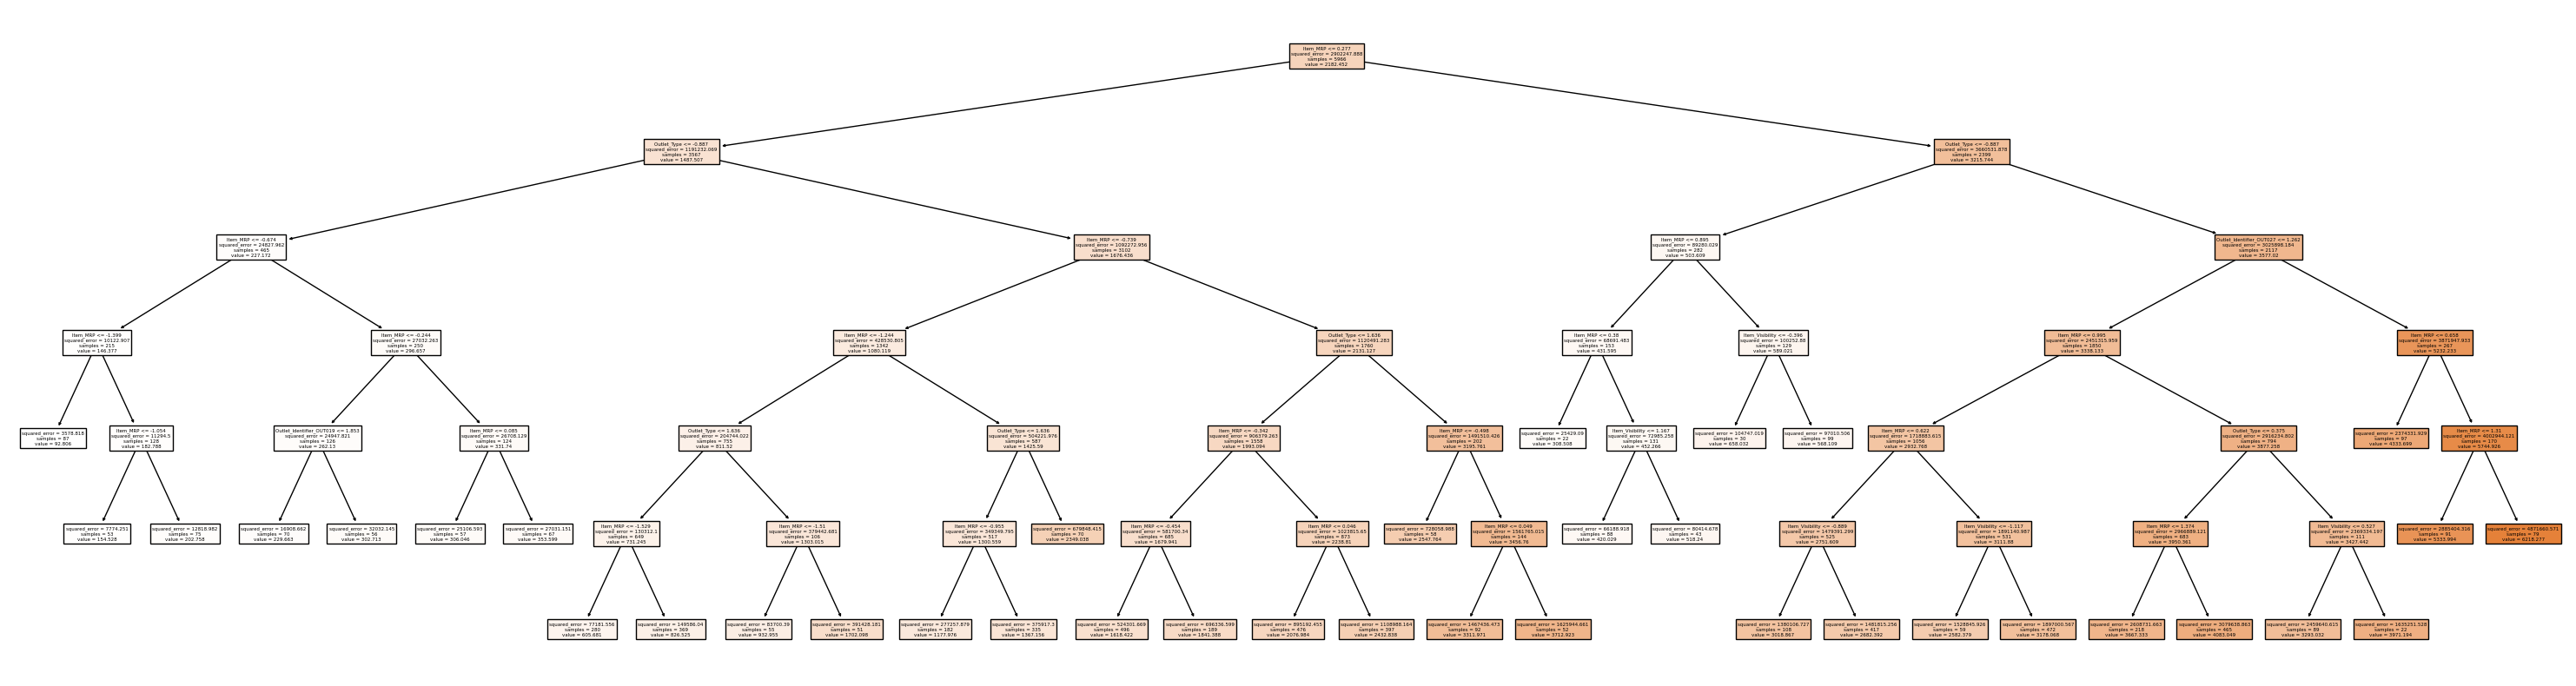

In [99]:
plt.figure(figsize=(38,10))
tree.plot_tree(decision_tree_reg, feature_names= x_train_df.columns,filled=True)
plt.show()

In [315]:
explainer_2 = shap.Explainer(decision_tree_reg.predict, x_train_df)
shap_values_2 = explainer_2(x_test_df)

Permutation explainer: 2558it [01:04, 32.78it/s]                                                                       


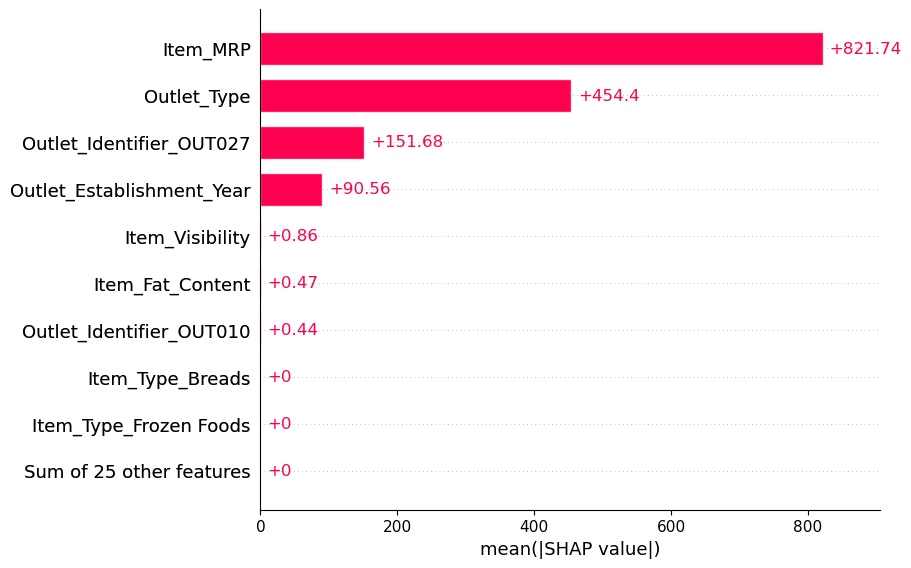

In [316]:
shap.plots.bar(shap_values_2)

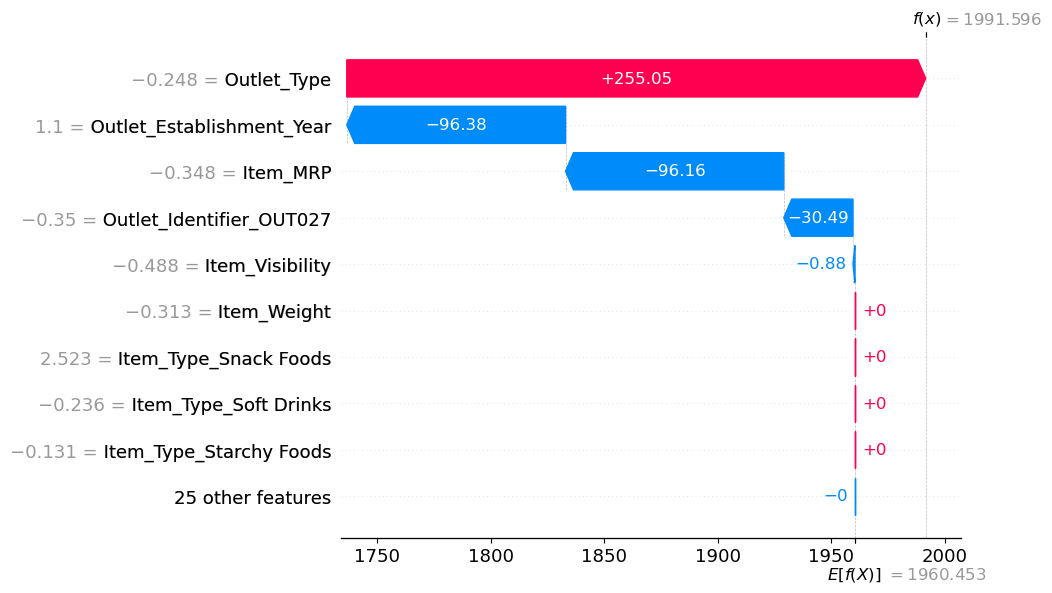

In [318]:
shap.plots.waterfall(shap_values_2[1])

### Result
- Feature importance seems more accurate

## 2. Random Forest 

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
random_forest_reg = RandomForestRegressor(n_estimators=35, max_depth=6,min_samples_split=100,min_samples_leaf=15 )
random_forest_reg.fit(x_train_df[["Item_MRP", "Outlet_Type"]], y_train_df)
random_forest_reg.score(x_test_df[["Item_MRP", "Outlet_Type"]], y_test_df)

0.5942266283044466

#### HyperParameter Tuning

In [73]:
# Manual
parameters={
#             'n_estimators': [33,35,37,39],
#             "max_depth": [4,5,6],
            "min_samples_split": [80,90,95,100],
            "min_samples_leaf": [x for x in [10,15,20]]
           }
random_forest_cv =GridSearchCV(random_forest_reg, parameters, scoring="r2", cv=3, n_jobs=-1, verbose=2)
random_forest_cv.fit(x_train_df[["Item_MRP", "Outlet_Type"]],y_train_df)
print(random_forest_cv.best_params_)
print(random_forest_cv.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'min_samples_leaf': 10, 'min_samples_split': 90}
0.6023084000289872


After Hyperparameter tuning => 0.60


Before => 0.54

In [67]:
explainer_3 = shap.Explainer(random_forest_reg.predict, x_train_df)
shap_values_3= explainer_3(x_test_df)

Permutation explainer: 2558it [03:36, 11.81it/s]                                                                       


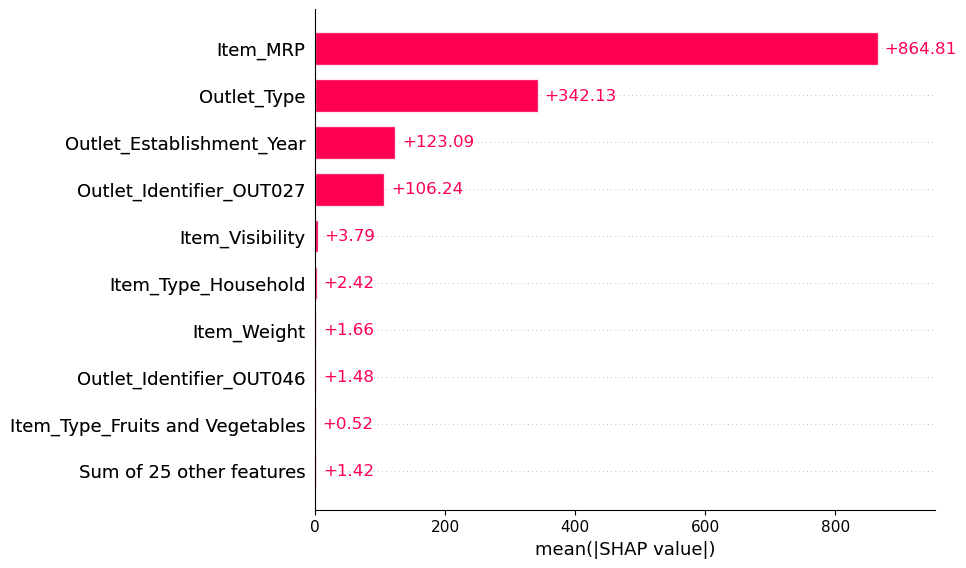

In [106]:
shap.plots.bar(shap_values_3)

## 3. XGBoost

In [3]:
from xgboost import XGBRegressor

In [19]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

parameters = {
    'max_depth': Integer(2,10),
    'learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'colsample_bylevel': Real(0.5, 1.0),
    'colsample_bynode' : Real(0.5, 1.0),
    'reg_alpha': Real(0.0, 10.0),
    'reg_lambda': Real(0.0, 10.0),
    'n_estimators': Integer(30,50)
}

opt = BayesSearchCV(xg_reg, parameters, cv=3, n_iter=10, scoring='r2', random_state=8) 
opt.fit(x_train_df,y_train_df)

BayesSearchCV(cv=3,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.3,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, ma...
                             'max_depth': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=30, high=50, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [20]:
opt.best_params_

OrderedDict([('colsample_bylevel', 0.5331080642783614),
             ('colsample_bynode', 0.7262320733948379),
             ('colsample_bytree', 0.5362052518135637),
             ('learning_rate', 0.1702054418337726),
             ('max_depth', 2),
             ('n_estimators', 41),
             ('reg_alpha', 5.016505750780453),
             ('reg_lambda', 1.964788283871643),
             ('subsample', 0.5258638996089925)])

In [21]:
opt.best_score_

0.5550799108399594

In [25]:
xg_reg=XGBRegressor(colsample_bytree=0.3,learning_rate=0.1,
                        max_depth=5,n_estimators=40,reg_alpha=0.75,reg_lambda=0.45,subsample=0.6,seed=42)

In [26]:
xg_reg.fit(x_train_df, y_train_df)
xg_reg.score(x_test_df,y_test_df)

0.5699209022032257

# SGD Regressor 

In [34]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

sgd_regressor = SGDRegressor()

sgd_regressor.fit(x_train_df, y_train_df)

y_pred = sgd_regressor.predict(x_test_df)

mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("r2:", r2)

print("root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute Error: 844.4269336075752
r2: 0.5593259271550789
root Mean Squared Error: 1134.8823741295353


***
#### Linear Model 

~0.55 for all, bad performance
- Linear Regression (deg=1)
- Polynomial Regression (deg=2)
- Ridge Regression (alpha=37)
- Lasso Regression (alpha=12)
- SGD Regression

#### Tree Model

- Decision Tree (depth-5) - 0.60 ==> feature selection improving accuracy
- Random Forest (Depth-5) (0.60)
- XGBoost (0.58)
***

#### ~Not working

In [36]:
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import mean_squared_log_error, make_scorer  
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score

In [37]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Random Forest': RandomForestRegressor(max_depth=5),
    'GradientBoosting Regressor':GradientBoostingRegressor(),
    'AdaBoost Regressor':AdaBoostRegressor()
}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, x_train_df[["Item_MRP", "Outlet_Type"]], y_train_df, scoring='r2', cv=5)
    
    print(f"{model_name}")
#     print(f"Cross-Validation Score: {cv_scores}")
    print(f"Average Score: {np.mean(cv_scores)}\n")

Linear Regression
Average Score: 0.48167130306214884

Decision Tree
Average Score: 0.5975777751198469

Random Forest
Average Score: 0.5995883419900616

GradientBoosting Regressor
Average Score: 0.5976598097099108

AdaBoost Regressor
Average Score: 0.4885809777174708



In [38]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Random Forest': RandomForestRegressor(max_depth=5),
    'GradientBoosting Regressor':GradientBoostingRegressor(),
    'AdaBoost Regressor':AdaBoostRegressor()
}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, x_train_df, y_train_df, scoring='r2', cv=5)
    
    print(f"{model_name}")
#     print(f"Cross-Validation Score: {cv_scores}")
    print(f"Average Score: {np.mean(cv_scores)}\n")

Linear Regression
Average Score: 0.5581813771492466

Decision Tree
Average Score: 0.5960139347471994

Random Forest
Average Score: 0.5993761709236278

GradientBoosting Regressor
Average Score: 0.5952883612634575

AdaBoost Regressor
Average Score: 0.5225668832567759



# Conclusion 

### Random Forest and Decision Tree is performing slightly better than other tree models